In [1]:
%matplotlib inline
import matplotlib.pyplot as pl
from scipy import *
from scipy.linalg import eigh

In [2]:
from matplotlib import rcParams
from IPython.display import HTML, Latex, display
set_printoptions(linewidth=180)
import json ; s = json.load(open("mplrc.json")) ; del json
rcParams.update(s)
rcParams['figure.figsize'] = 12,6

def css_styling():
    styles = open("custom.css", "r").read()
    return HTML(styles)
# css_styling()
HTML(open("custom.css", "r").read())

Following, some utility functions:
<dl>

<dt>redeig</dt>
<dd>solves the reduced eigenvalue problem</dd>

<dt>plot_eigenvectors</dt>
<dd>given a shear type building, this function plots its eigenvectors starting with a zero displacement at ground level (zero displacement that is not contained in any of the eigenvectors...)</dd>

<dt>same_sign</dt>
<dd>library functions return eigenvectors with arbitrary signs, this function
change the sign of a whole column if the sign of the last element is negative</dd>

<dt>error</dt>
<dd>starting from a matrix of errors, computes the SRSS column by column</dd>
</dl>

In [3]:
def redeigh(K, M, phi):
    """Solves the reduced eigenproblem in subspace iteration method.
    Input:  phi, a 2-d array containing the current subspace;
    output: 1. 1-d array of eigenvalues estimates;
            2. 2-d array of eigenvector estimates in Ritz coordinates."""
    
    # compute the reduced matrices
    Mr = phi.T*M*phi
    Kr = phi.T*K*phi
    
    # solve the reduced eigenproblem, using a library function
    return eigh(Kr,Mr)

In [4]:
def plot_eigenvectors(evecs):
    
    floors = range(shape(evecs)[0]+1)
    
    for i,v in enumerate(evecs.transpose()):
        pl.plot(floors,
                concatenate(([0],ravel(v))),
                linewidth=2, label='Mode #%d'%(i+1,))
    
    pl.hlines(0,0,floors[-1],colors='#777777')
    ymn, ymx = pl.ylim() ; pl.ylim(ymn, 1.2*ymx)
    pl.xticks(floors) ; pl.legend(loc=9, ncol=5)
    pl.show()

In [5]:
def same_sign(arr):
    "modifies \"in place\" a 2-D array, forcing the last row to be non-negative."
    for col in asarray(arr).transpose():
        col *= sign(col[-1])
    return None

In [6]:
def error(arr):
    err = []
    for col in arr.transpose():    
        err.append(sqrt(sum(ravel(col)*ravel(col))))
    return err

# Shear-Type Building, Subspace Iteration 

We analyse a 2D frame, with negligible flexural deformations in beams and negligible 
shear and axial deformation, all the deformations are due to the lateral flexibility
of columns. Under these assumptions, we can study a dynamic model where we have 1 DOF
for each floor.

Our frame has twelve floors and hence 12 DOF. DOF are numbered from the bottom up to 
the top if the frame.

We need only the lowest 4 eigenvalues-eigenvectors, so we can use the subspace iteration method with a base
`phi` that's a 12x4 array.

The floor masses are all the same, while the story stiffnesses are decreasing with height, starting from
23$k$ for storey 1, i.e., between the ground and the first floor, down to 12$k$

We start creating a list containing the lateral stiffnesses, taking into account also the (zero!) stiffness of the (non existing) storey above the top, as this trick is handy when definining the coefficients of the stiffness matrix. 

In [7]:
story_stiffness = list(range(23,11,-1))
story_stiffness.append(0)
story_stiffness = array(story_stiffness)
y = array(range(13))
print("Storey:      ",','.join([" %2d"%(i+1,) for i in y]))
print("Stiffness:   ",",".join([" %2d"%(s,) for s in story_stiffness]))

Storey:         1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13
Stiffness:     23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12,  0


We construct the structural matrices, `M` being a unit matrix and `K`  is constructed as the superposition of 3
matrices of which we specify one of the diagonals. The index set `[:-1]` means from the first to the penultimate,
`[1:]` means from the second to the last and `[1:-1]` means from the second to the penultimate.

While we are at it, we compute also the dynamic matrix.

In [8]:
M = matrix(eye(12))
ss = story_stiffness
K = (diag(+ss[:-1] + ss[1:]) +
     diag(-ss[1:-1], k=+1)   +
     diag(-ss[1:-1], k=-1)   ) * 1.0
K = matrix(K)
D = K.I*M

In [9]:
print ("normalized mass matrix M/m:")
print (M)
print ()
print ("normalized stiffness matrix K/k:")
print (K)

normalized mass matrix M/m:
[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]]

normalized stiffness matrix K/k:
[[ 45. -22.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [-22.  43. -21.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0. -21.  41. -20.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0. -20.  39. -19.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0. -19.  37. -18.   0.   0.   0.   0.   0.   0.]
 [  0.   0

To have something to compare our approximate results with, we compute, using a library function, a very
good approximation to the eigenvalues and eigenvectors of our system.

In [10]:
evals, evecs = eigh(K,M,eigvals=(0,3))
same_sign(evecs)
print("first four eigenvalues of the system")
print(evals,"\n")
print("first four eigenvectors of the system")
print(evecs)

first four eigenvalues of the system
[  0.30522543   2.38337068   6.39983138  12.0934459 ] 

first four eigenvectors of the system
[[ 0.04134929 -0.11705278  0.18702514 -0.2464852 ]
 [ 0.08400443 -0.22674522  0.32814555 -0.36868084]
 [ 0.12746979 -0.31592693  0.37598234 -0.28438   ]
 [ 0.17116307 -0.37191918  0.3058998  -0.02390741]
 [ 0.21440635 -0.38420463  0.12909148  0.26549126]
 [ 0.25641635 -0.34630027 -0.1034375   0.39259518]
 [ 0.29629371 -0.25761554 -0.31070451  0.24789177]
 [ 0.33301114 -0.12501344 -0.40664718 -0.09322222]
 [ 0.36540017  0.03629236 -0.3354878  -0.38191861]
 [ 0.39213631  0.20294157 -0.1058838  -0.36132817]
 [ 0.41172215  0.34520341  0.19350809 -0.00302288]
 [ 0.42246781  0.43075809  0.4146477   0.38818761]]


The initial base is a 12x4 matrix, with linearly independent columns. To start with a very bad set,
we choose a matrix of random numbers. The call to `random.seed` insures repeatability of the results.

In [11]:
random.seed(8+8+1988) # good luck
phi = matrix(random.random((12,4)))-0.5
print("initial subspace vectors")
print(phi)

initial subspace vectors
[[ 0.08774829  0.30443898 -0.0296647  -0.01430415]
 [ 0.25873875  0.291916    0.08631742  0.47198061]
 [ 0.06319749 -0.42881828 -0.08097817 -0.05726654]
 [-0.00735125 -0.35594205 -0.34629339  0.16050985]
 [-0.28991909 -0.43293504  0.46643776  0.42592043]
 [ 0.3226598   0.20420248  0.49683776  0.48270073]
 [ 0.23320919  0.4463363  -0.36077892 -0.21269507]
 [ 0.33961838 -0.18947759  0.22706267  0.1577504 ]
 [ 0.44644677  0.02433346 -0.06984466  0.15335013]
 [-0.22501533  0.44581842 -0.14249575 -0.07682477]
 [ 0.21228054 -0.34494495 -0.44618718  0.31013833]
 [-0.30559631 -0.36312087  0.19230842  0.35211024]]


It's time to iterate, starting from a very bad choice for the initial base vectors.

 1. compute evals and evecs in Ritz coordinates
 1. compute estimates of evals and evecs in natural coordinates (no-op for evals, matrix mult for evecs)
 1. compute new base for next iteration applying matrix iteration procedure to the 
    estimated eigenvectors
 1. display the current results

In [12]:
description = Latex(r'$$\text{error}_i =  \sqrt{\textstyle{\sum_j} \Delta\psi_{ji}^2}$$')

def iterate(phi, i):

    display(HTML("<h3>Iteration #%2.2d</h3>"%(i,)))

    ritz_evals, ritz_evecs = redeigh(K, M, phi)
    
    # "_e" is for "estimate"
    evals_e = ritz_evals
    evecs_e = phi*ritz_evecs
    same_sign(evecs_e) # force the same sign in the last component of evecs
    
    # compute the new base
    phi = D*evecs_e
    
    # show what we have done
    print("\"Real\" eigenvalues        ", evals)
    print("Estimated eigenvalues     ", evals_e)
    print("Relative error (e-r)/r    ", (evals_e-evals)/evals_e)
    print("2-norm of the difference between estimated eigenvectors and \"real\" ones")
    display(description)
    print(error(evecs_e-evecs))

    display(HTML("<h5>The normalised shapes at iteration #%2.2d</h5>"%(i)))

    plot_eigenvectors(evecs_e)
    return phi

"Real" eigenvalues         [  0.30522543   2.38337068   6.39983138  12.0934459 ]
Estimated eigenvalues      [ 13.10440076  30.01414993  38.43979497  41.08619637]
Relative error (e-r)/r     [ 0.97670817  0.92059176  0.83351026  0.70565672]
2-norm of the difference between estimated eigenvectors and "real" ones


<IPython.core.display.Latex object>

[1.1222149251125213, 1.1796367709331772, 1.3870147933196975, 1.256436091582926]


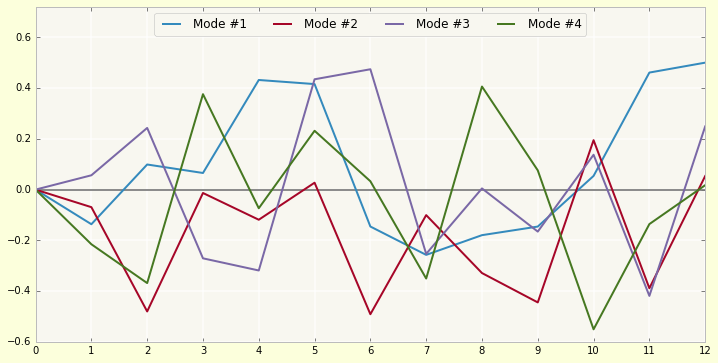

In [13]:
phi = iterate(phi, 1)

"Real" eigenvalues         [  0.30522543   2.38337068   6.39983138  12.0934459 ]
Estimated eigenvalues      [  0.31010674   3.32457743   9.80770616  30.93579931]
Relative error (e-r)/r     [ 0.01574074  0.28310568  0.34746909  0.60907925]
2-norm of the difference between estimated eigenvectors and "real" ones


<IPython.core.display.Latex object>

[0.026013536021439767, 0.33275412412715338, 0.62533045465733716, 1.1454940039193922]


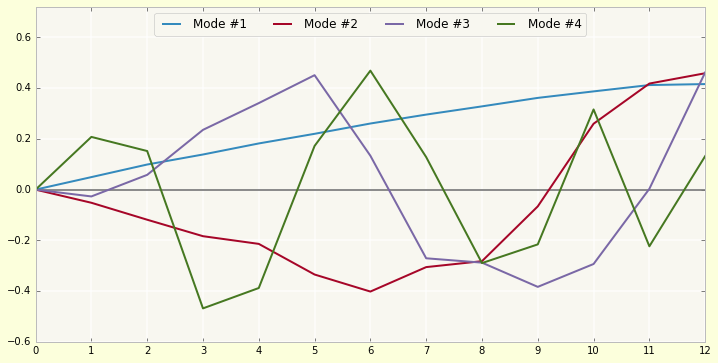

In [14]:
phi = iterate(phi, 2)

"Real" eigenvalues         [  0.30522543   2.38337068   6.39983138  12.0934459 ]
Estimated eigenvalues      [  0.30522787   2.40339175   6.88393993  20.46143244]
Relative error (e-r)/r     [  8.00522357e-06   8.33033770e-03   7.03243422e-02   4.08963868e-01]
2-norm of the difference between estimated eigenvectors and "real" ones


<IPython.core.display.Latex object>

[0.00043832269195536637, 0.043379390953476704, 0.25046374787469561, 0.72386302239959466]


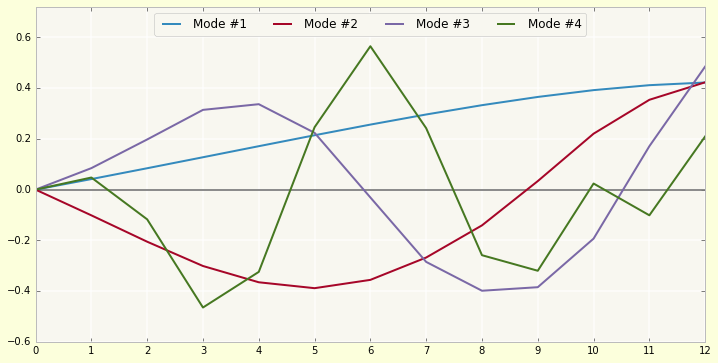

In [15]:
phi = iterate(phi, 3)

"Real" eigenvalues         [  0.30522543   2.38337068   6.39983138  12.0934459 ]
Estimated eigenvalues      [  0.30522543   2.3836799    6.4585566   13.94679419]
Relative error (e-r)/r     [  2.01624113e-09   1.29721474e-04   9.09262310e-03   1.32887047e-01]
2-norm of the difference between estimated eigenvectors and "real" ones


<IPython.core.display.Latex object>

[5.4263989023072967e-06, 0.0041972988334928549, 0.070432051384798022, 0.33120323277454672]


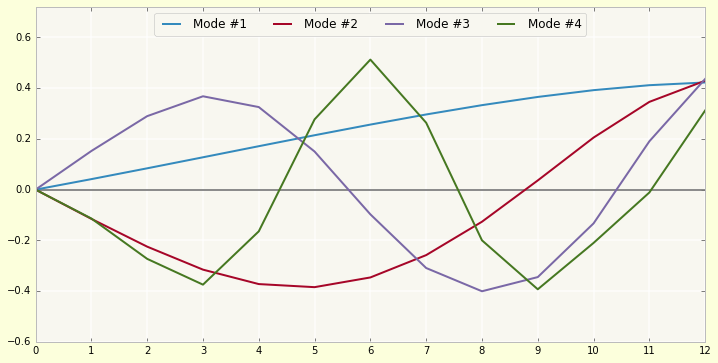

In [16]:
phi = iterate(phi, 4)

"Real" eigenvalues         [  0.30522543   2.38337068   6.39983138  12.0934459 ]
Estimated eigenvalues      [  0.30522543   2.38337354   6.40388404  12.42305865]
Relative error (e-r)/r     [  3.09723511e-13   1.19819322e-06   6.32844409e-04   2.65323353e-02]
2-norm of the difference between estimated eigenvectors and "real" ones


<IPython.core.display.Latex object>

[5.8555644944730863e-08, 0.00035564436208733989, 0.015135674095041971, 0.14182338701018984]


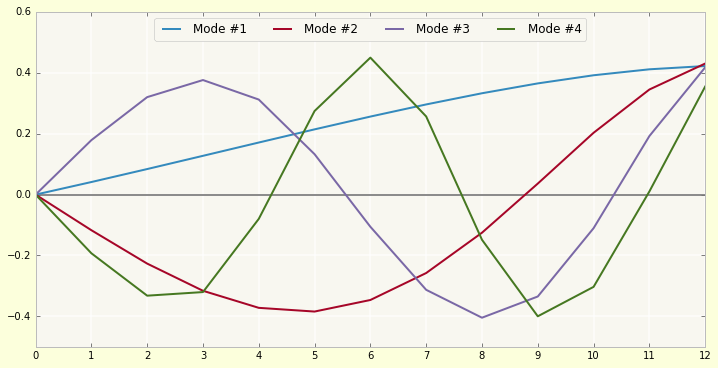

In [17]:
phi = iterate(phi, 5)

Notice how slowly the error index decreases for the two last eigenvector... 
we have did almost our best for them.

Using a Ritz base with less than 16 (8+8) vectors, we expect (last slide)
fast convergence for the lower half
of the eigenvectors and a _not so fast_ convergence for the remaining ones (I mean,
_eventually_ all the eigenvectors will converge, what is under discussion is the 
_velocity_ of convergence).

I'd say that this can be seen also in this example.